In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [7]:
def add_salt_and_pepper_noise(image, salt_prob, pepper_prob):
    noisy_image = image.copy()
    total_pixels = image.size
    num_salt = int(total_pixels * salt_prob)
    num_pepper = int(total_pixels * pepper_prob)
    
    salt_coords = [np.random.randint(0, i - 1, num_salt) for i in image.shape]
    pepper_coords = [np.random.randint(0, i - 1, num_pepper) for i in image.shape]
    
    noisy_image[salt_coords[0], salt_coords[1]] = 255
    noisy_image[pepper_coords[0], pepper_coords[1]] = 0
    
    return noisy_image

def add_gaussian_noise(image, mean=0, std=25):
    gaussian = np.random.normal(mean, std, image.shape).astype(np.uint8)
    noisy_image = cv2.add(image, gaussian)
    return noisy_image

def alpha_trimmed_mean_filter(image, d=2, kernel_size=3):
    padded_image = cv2.copyMakeBorder(image, 1, 1, 1, 1, cv2.BORDER_REFLECT)
    filtered_image = np.zeros_like(image)
    
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            kernel = padded_image[i:i+kernel_size, j:j+kernel_size].flatten()
            sorted_kernel = np.sort(kernel)
            trimmed_kernel = sorted_kernel[d//2:-d//2]  # Remove d/2 elements from both ends
            filtered_image[i, j] = np.mean(trimmed_kernel)
    
    return filtered_image.astype(np.uint8)

def adaptive_local_noise_reduction(image, var_noise=400):
    mean_filter = cv2.boxFilter(image, -1, (3, 3))
    var_local = cv2.boxFilter(image**2, -1, (3, 3)) - mean_filter**2
    
    mask = var_local > 0
    filtered_image = image.copy()
    filtered_image[mask] = image[mask] - ((var_noise / var_local[mask]) * (image[mask] - mean_filter[mask]))
    
    return filtered_image.astype(np.uint8)

def adaptive_median_filter(image, max_kernel_size=7):
    padded_image = cv2.copyMakeBorder(image, max_kernel_size//2, max_kernel_size//2, max_kernel_size//2, max_kernel_size//2, cv2.BORDER_REFLECT)
    filtered_image = np.zeros_like(image)
    
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            kernel_size = 3
            while kernel_size <= max_kernel_size:
                kernel = padded_image[i:i+kernel_size, j:j+kernel_size].flatten()
                Z_min, Z_max, Z_med = np.min(kernel), np.max(kernel), np.median(kernel)
                A1, A2 = Z_med - Z_min, Z_med - Z_max
                
                if A1 > 0 and A2 < 0:
                    B1, B2 = int(image[i, j]) - int(Z_min), int(image[i, j]) - int(Z_max)
                    if B1 > 0 and B2 < 0:
                        filtered_image[i, j] = image[i, j]
                    else:
                        filtered_image[i, j] = Z_med
                    break
                else:
                    kernel_size += 2
            else:
                filtered_image[i, j] = Z_med
    
    return filtered_image.astype(np.uint8)

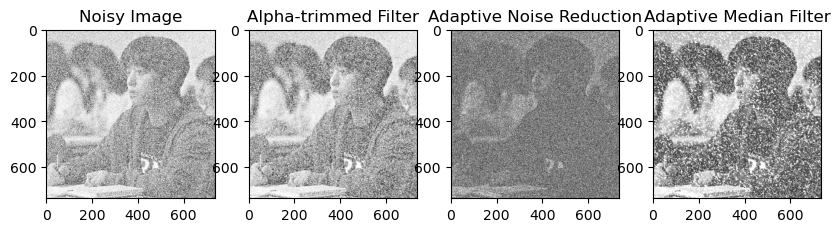

In [9]:
# Load Image
gray_image = cv2.imread("image.jpg", cv2.IMREAD_GRAYSCALE)

# Add noise
sp_noisy = add_salt_and_pepper_noise(gray_image, 0.02, 0.02)
gaussian_noisy = add_gaussian_noise(sp_noisy)

# Apply filters
alpha_filtered = alpha_trimmed_mean_filter(gaussian_noisy, d=2)
adaptive_filtered = adaptive_local_noise_reduction(gaussian_noisy)
adaptive_median_filtered = adaptive_median_filter(gaussian_noisy)

# Display Results
plt.figure(figsize=(10, 8))
plt.subplot(1, 4, 1)
plt.imshow(gaussian_noisy, cmap='gray')
plt.title('Noisy Image')

plt.subplot(1, 4, 2)
plt.imshow(alpha_filtered, cmap='gray')
plt.title('Alpha-trimmed Filter')

plt.subplot(1, 4, 3)
plt.imshow(adaptive_filtered, cmap='gray')
plt.title('Adaptive Noise Reduction')

plt.subplot(1, 4, 4)
plt.imshow(adaptive_median_filtered, cmap='gray')
plt.title('Adaptive Median Filter')

plt.show()
